<a href="https://colab.research.google.com/github/rafelsiregar/imagemlp/blob/master/ML_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer Perceptron from scratch

Referensi dari video bu Afia

In [ ]:
from random import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import cv2

##Activation Function

In [ ]:
def sigmoid(x):
  return 1.0 / (1.0+math.exp(-x))

In [ ]:
def mse(output, target):
  err = 0
  for outp, targ in zip(output, target):
    err += 1/2 * (outp - targ)**2
  return err

##class Network 
Berisi 3 layer: input, hidden dan output. Tiap layer berisi neuron yang berisi:
- `weights`: array np berisi weight tiap neuron dari layer sebelumnya ke dirinya
- `bias`  : nilai bias untuk neuron ini, dipakai untuk menghitung nilai aktivasi
- `output`: nilai output untuk neuron ini, yaitu nilai aktivasinya

In [ ]:
class Network:
  def __init__(self, inp_n = 0, hid_n = 0, out_n = 0):
    self.shape = {'input': inp_n, 'hidden': hid_n, 'output': out_n}
    self.layers = [
                  # hidden layer
                  [{
                      'weights' : np.array([random() for i in range(inp_n)]),
                      'bias'    : random(),
                      'output'  : 0
                  } for j in range(hid_n)],
                   
                  # output layer
                  [{
                      'weights' : np.array([random() for i in range(hid_n)]),
                      'bias'    : random(),
                      'output'  : 0
                  } for j in range(out_n)]
    ]
  
 
  # Forward propagate
  # Tiap neuron di hidden dihitung aktivasinya, kemudian dibawa ke output layer
  # Return sebuah array berisi aktivasi dari tiap neuron output layer
  def forward(self, data):
    # Input ke hidden
    for neuron in self.layers[0]:
      neuron['output'] = sigmoid(np.dot(data, neuron['weights']) + neuron['bias'])
 
    hid_array = [neuron['output'] for neuron in self.layers[0]]
    
    # Hidden ke output
    for neuron in self.layers[1]:
      neuron['output'] = sigmoid(np.dot(hid_array, neuron['weights']) + neuron['bias'])
    
    out_array = [neuron['output'] for neuron in self.layers[1]]
 
    return out_array
 
  # Backward propagate
  # Pertama delta tiap output neuron dicari dengan rumus
  # delta = (aktivasi - prediksi) * aktivasi * (1 - aktivasi)
  # kemudian bobot hidden -> output diupdate pake rumus
  # nwe_weight = old_weight - learn_rate*delta*
  def backward(self, data, output, target, learn_rate):
      delta_array_out = []
      # output ke hidden
      ## cari delta tiap output neuron
      for index, neuron in enumerate(self.layers[1]):
        delta = (neuron['output'] - target[index]) * neuron['output'] * (1 - neuron['output'])
        delta_array_out.append(delta)
      
      ## update bobot axon dari hidden ke output
      for index, neuron in enumerate(self.layers[1]):
        new_weights = [neuron['weights'][i] - (learn_rate * delta_array_out[index] * self.layers[0][i]['output']) for i in range(len(neuron['weights']))]
        neuron['weights'] = new_weights
        neuron['bias'] = neuron['bias'] - learn_rate * delta_array_out[index]
      
      
      delta_array_hid = []
      # hidden ke input
      ## cari delta tiap hidden neuron
      for index, neuron in enumerate(self.layers[0]):
        inweight = [neur['weights'][index] for neur in self.layers[1]]
        potential = np.dot(inweight, delta_array_out)
        delta = potential * neuron['output'] * (1 - neuron['output'])
        delta_array_hid.append(delta)
      
      ## update bobot axon dari input ke hidden
      for index, neuron in enumerate(self.layers[0]):
        new_weights = [neuron['weights'][i] - (learn_rate * delta_array_hid[index] * data[i]) for i in range(len(neuron['weights']))]
        neuron['weights'] = new_weights
        neuron['bias'] = neuron['bias'] - learn_rate * delta_array_hid[index]
   
 
  def train(self, dataset, labels, epochs = 1, learn_rate = 0.5):
    errors = []
    accuracies = []
    for i in range(epochs):
      error = 0
      correct = 0
      print('Training epoch', i + 1, '...')
      for data, label in zip(dataset, labels):
        #print('data:', *data)
        out_array = self.forward(data)
        if(out_array.index(max(out_array)) == label):
          correct += 1
        label_array = [1 if i == label else 0 for i in range(len(self.layers[1]))]
        error += mse(out_array, label_array)
        self.backward(data, out_array, label_array, learn_rate)
      print('Error:', error, '\n')
      errors.append(error)
      accuracies.append(correct / len(dataset))
    
    print('Training done')
 
    return errors, accuracies
  
  def test(self, dataset, labels):
    print('Testing start...\n')
    correct = 0
    for data, label in zip(dataset, labels):
      output = self.forward(data)
      prediction = output.index(max(output))
      print('predicted', prediction, 'should be', label, end = '')
      if(prediction == label):
        print('....ok')
        correct += 1
      else:
        print('....miss')
    
    return correct / len(dataset)
  
  def predict(self, dataset):
    predictions = []
    for data in dataset:
      output = self.forward(data)
      prediction = output.index(max(output))
      predictions.append(prediction)
    
    return prediction

## Fetch data and parsing Function

In [ ]:
# Return 2 buah list isi dataset:
# list pertama adalah dataset (X) berupa ndarray
# list kedua adalah labelnya (y) berupa ndarray
# bisa langsung jadi parameter buat test_train_split()
def load_data():
  path = 'flowers'
  flowers = os.listdir(path)
  print(flowers)

  label = dict(zip(flowers, [0, 1, 2]))

  X = []
  y = []

  for folder in flowers:
    images = os.listdir(os.path.join(path, folder))
    X.extend([resize(
                grayscale(
                    cv2.imread(os.path.join(path, folder, image))
                    ),
                    320,
                    240
                ) for image in images])
    y.extend([label[folder]] * len(images))
  
  return X, y

###Image and data Transform Function

In [ ]:
def resize(img, height, width):
  return cv2.resize(img,(height, width), interpolation = cv2.INTER_AREA)

def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
# ubah ke 1 dimensi
def flatten(data):
  '''
  Flatten

  Parameters
  ----------
  X: list(list()) `Data input layer 2 dimensi hanya 1 data`

  Return
  ------
  X_new: list() `Data dijadikan 1 dimensi`
  '''
  np_data = np.array(data)
  return np_data.flatten()

# ubah data pixel ke range 0 - 1
def normalize(data):
  '''
  Normalize

  Parameters
  ----------
  X: list() `Data input layer 1 dimensi hanya 1 data`

  Return
  ------
  X_new: list() `Data dijadikan antara 0 dan 1`
  '''
  np_data = np.array(data)
  return np_data/255.

['dandelion', 'rose', 'sunflower']


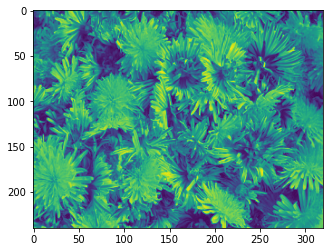

In [ ]:
# sudah dilakukan grayscale dan resize
data_img, data_label = load_data()

# show image
plt.imshow(data_img[0])

In [ ]:
# Ubah ke 1 dimensi
# Data dijadikan range 0 sampai 1
data_normal = []
for img in data_img:
  flat = flatten(img)
  normal = normalize(flat)
  data_normal.append(normal)

# Split data train & test
x_train, x_test, y_train, y_test = train_test_split(data_normal, data_label, train_size=0.8)
x_train, y_train = shuffle(x_train, y_train)


###Defining Model

In [ ]:
input_length = len(x_train[0])
hidden_length = 10
output_length = max(y_train) #Num of classes

# Init network
network = Network(input_length, hidden_length, output_length)

# Training
errors, accuracy = network.train(x_train, y_train, epochs = 50, learn_rate = 0.1)

Training epoch 1 ...
Error: 121.71143030098918 

Training epoch 2 ...
Error: 54.733743199880806 

Training epoch 3 ...
Error: 54.833461972770195 

Training epoch 4 ...
Error: 54.833462470015554 

Training epoch 5 ...
Error: 54.83346247001771 

Training epoch 6 ...
Error: 54.83346247001771 

Training epoch 7 ...
Error: 54.83346247001771 

Training epoch 8 ...
Error: 54.83346247001771 

Training epoch 9 ...
Error: 54.83346247001771 

Training epoch 10 ...
Error: 54.83346247001771 

Training epoch 11 ...
Error: 54.83346247001771 

Training epoch 12 ...
Error: 54.83346247001771 

Training epoch 13 ...
Error: 54.8334624700177 

Training epoch 14 ...
Error: 54.83346247001771 

Training epoch 15 ...
Error: 54.83346247001771 

Training epoch 16 ...
Error: 54.83346247001771 

Training epoch 17 ...
Error: 54.83346247001771 

Training epoch 18 ...
Error: 54.83346247001771 

Training epoch 19 ...
Error: 54.83346247001771 

Training epoch 20 ...
Error: 54.83346247001771 

Training epoch 21 ...
Erro

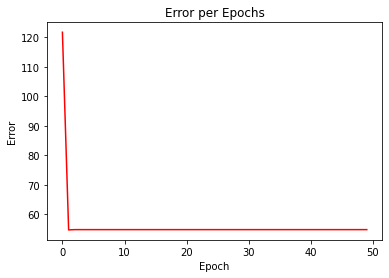

In [ ]:
# plot errors and accuracy
plt.plot(errors, color = 'r')
plt.title('Error per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

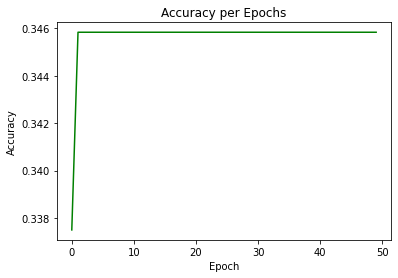

In [ ]:
plt.plot(accuracy, color = 'g')
plt.title('Accuracy per Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# TEST
accuracy = network.test(x_test, y_test)
print('Test Accuracy:', accuracy)

Testing start...

predicted 1 should be 2....miss
predicted 1 should be 1....ok
predicted 1 should be 0....miss
predicted 1 should be 2....miss
predicted 1 should be 2....miss
predicted 1 should be 2....miss
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 1 should be 2....miss
predicted 1 should be 2....miss
predicted 1 should be 0....miss
predicted 1 should be 0....miss
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 1 should be 2....miss
predicted 1 should be 1....ok
predicted 1 should be 1....ok
predicted 1 should be 2....miss
predicted 1 should be 2....miss
predicted 1 should be 1....ok
predicted 1 should be 0....miss
predicted 1 should be 0....miss
predicted 1 should be 2....miss
predicted 1 should be 2....miss
predicted 1 should be 0....miss
predicted 1 should be 2....miss
predicted 1 should be 2....miss
predicted 1 should be 0....miss
predicted 1 should be 1....ok
predicted 1 should be 0....miss
predicted 